In [1]:
import simulacra.star
import simulacra.tellurics
from simulacra.star import PhoenixModel

import random
import numpy as np

import astropy.io.fits
import astropy.time as at

import astropy.units as u
import astropy.coordinates as coord
import astropy.constants as const

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


<h1>Simulacra: An Introduction to Simulating Spectrograph Data</h1>
This package should be used to simulate spectrographs by creating a star with a given flux, various transmission models (gas cell and tellurics), and a detector. Then simulating the detector at given start times for an exposure time.

$$ F_{\lambda ij} t_{exp} A_{ste} \frac{A_{telescope}}{A_{sphere}} d \lambda_j = N
^{exp}_{ij}$$

this formula converts from the stellar flux denisty to the expected photon number on the detector.

In [2]:
ra, dec = np.random.uniform(0,360) * u.degree, np.random.uniform(0,80) * u.degree
obs = 'APO'
loc = coord.EarthLocation.of_site(obs)
target = coord.SkyCoord(ra,dec,frame='icrs')

Functions from the star module can be used to select times to view a given star from some observatory.

In [3]:
tstart = at.Time('2020-01-01T08:10:00.123456789',format='isot',scale='utc')
tend   = tstart + 365 * u.day
night_grid = simulacra.star.get_night_grid(loc,tstart,tend,steps_per_night=10)
possible_times, airmass = simulacra.star.get_realistic_times(target,loc,night_grid)

In [4]:
epoches = 2

Now we selected some random sample of these to observe at and the airmasses at those times

In [5]:
obs_ints = random.sample(range(len(airmass)),epoches)
obs_times, obs_airmass = possible_times[obs_ints], airmass[obs_ints]

<h2>Tellurics Model</h2>
The tellurics model requires these airmasses at the time of observation. However each of the pressure, temperatures, and humidities can be set by the user after initialization. If a single value is passed that is used for every epoch. Or you can pass it an array of quantities of size equal to the number of epoches.

In [6]:
wave_min = 590*u.nm
wave_max = 592*u.nm
tellurics_model = simulacra.tellurics.TelFitModel(wave_min,wave_max,loc)

Define some atmospheric parameters for the tellurics. These can either be constant over all time or an array with the same length as the number of epoches.

In [7]:
tellurics_model.pressure    = 875 * u.hPa
tellurics_model.temperature = 300 * u.Kelvin
tellurics_model.humidity    = 50.0

<h2>Star Model</h2>
Here we define the star model with some temperature, distance, logg, and companion parameters. The logg, T, z, and alpha parameters must correspond to an appropriate atmosphere model from the PHOENIX libraray online. Then also give it some companion parameters that could affect its velocity. This is what we will be trying to find use jabble.

using saved wave file
data/stellar/PHOENIX/lte04800-1.00-1.0.Alpha=+0.40.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits
using saved flux file
erg / (cm3 s)
reading in data/stellar/PHOENIX/WAVE_PHOENIX-ACES-AGSS-COND-2011.fits


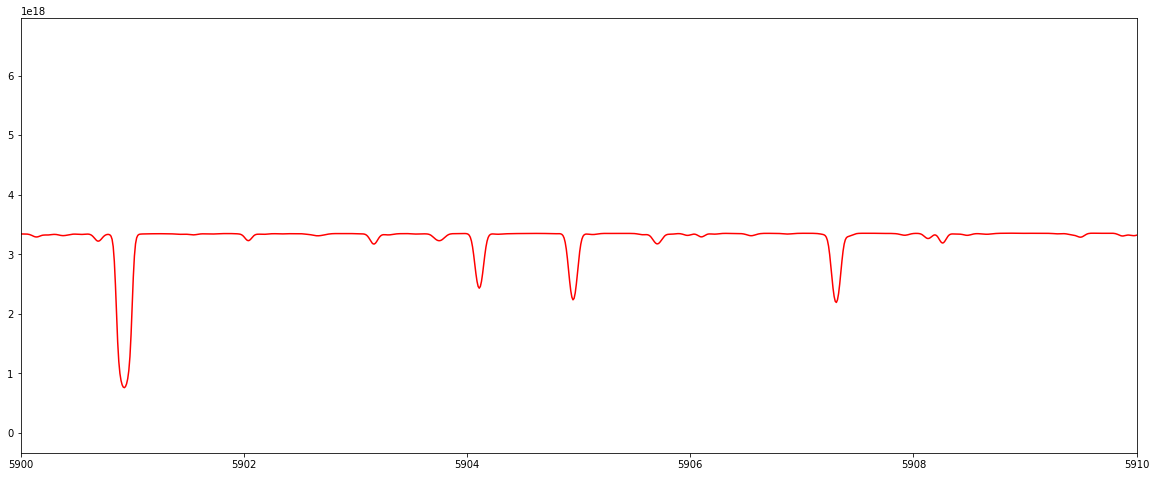

In [8]:
logg = 1.0
T    = 4800
z    = 1.0
alpha= 0.4
amplitude = 2 * u.m/u.s
period    = 65 * u.day
stellar_model = PhoenixModel(alpha,z,T,logg,target,amplitude,period)

In [9]:
from simulacra.detector import Detector, spacing_from_res

<h2>Detector</h2>
Here we define our detector giving it an aperature area, resolution, dark current, read noise, and ccd efficiency. All of these can be except area can be given as an array of the same size as the wave_grid (eg. if the detector has varying resolution or noise levels)

In [10]:
resolution = 130_000
area = 10 *u.m**2
exp_times = 8 * np.ones(epoches)* u.minute 
dark_current = 100/u.s
read_noise   = 100
ccd_eff      = 0.99

delta_x = spacing_from_res(resolution)
x_grid = np.arange(np.log(wave_min.to(u.Angstrom).value),np.log(wave_max.to(u.Angstrom).value),delta_x)
wave_grid = np.exp(x_grid) * u.Angstrom

detector = Detector(stellar_model,resolution,loc,area,wave_grid,dark_current,read_noise,ccd_eff)

In [11]:
detector.add_model(tellurics_model)

<h2>Gas Cell</h2>
Optionally, add the gas cell to the detector for simulations of the Keck HiRES spectrograph.

In [12]:
from simulacra.gascell import GasCellModel
gascell_model = GasCellModel('data/gascell/keck_fts_inUse.idl')
detector.add_model(gascell_model)

<h2>Simulator</h2>
Now comes the bulk of the work, run the simulation with the given transmission models, star, detector at the given times for some exposure times.

In [13]:
data = detector.simulate(obs_times,exp_times)

resetting...


generating spectra...
humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 16891.89189189189
 freqmax(cm-1): 16949.15254237288
 angle: 33.4641270749277

humidity: 50.0
 pressure: 875.0
 temperature: 300.0
 lat: 32.78000000000001
 elevation: 2.797999999999601
 freqmin(cm-1): 16891.89189189189
 freqmax(cm-1): 16949.15254237288
 angle: 27.619327467286745

<simulacra.tellurics.TelFitModel object at 0x7f7fa35560f0> [1.6178939059585673e-06, 2.2694525991795444e-07, 2.2694525991795444e-07]
<simulacra.gascell.GasCellModel object at 0x7f7fa7461198> [1.6178939059585673e-06, 2.2694525991795444e-07, 2.2694525991795444e-07, 7.868814098088706e-07, 7.868814098088706e-07]
interpolating spline...
0
1
convolving...
0
1
interpolating lanczos...
f_exp 0: 3.617454046489721e+50
f_exp 1: 3.6306368453555796e+50
generating signal to noise ratios...
100.0 48000.0 1.3826609037787525e+50
100.0 48000.0 1.4127133328526074e+50
adding noise...
snr 0:

Save file to pickle jar

In [14]:
filename = 'out/datatest4.pkl'
data.to_pickle(filename)
data.to_h5('out/datatest4.h5')

saving time
quantity
epoches  saving as string
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
quantity
alpha  saving as string
quantity
quantity
fluxname  saving as string
generate_spectra  saving as string
quantity
quantity
logg  saving as string
outdir  saving as string
quantity
plot  saving as string
plot_interpolated  saving as string
quantity
quantity
target  saving as string
temperature  saving as string
quantity
quantity
wavename  saving as string
quantity
quantity
quantity
quantity
quantity
a  saving as string
add_model  saving as string
quantity
checkmax  saving as string
checkmin  saving as string
quantity
epsilon  saving as string
gamma  saving as string
quantity
quantity
quantity
lsf_centering  saving as string
lsf_const_coeffs  saving as string
resolution  saving as string
sigma  saving as string
sigma_range  saving as string
simulate  saving as string
stellar_model  saving as string
transmission_models  saving as string


c: read noise <br>
d: dark current <br>
Q: ccd efficiency <br>
f^{exp}: expected flux in photon number <br>
f^{readout}: readout flux in photon number

$$ SNR_{ij} = \frac{Q_j N^{exp}_{ij}}{\sqrt{c_j + d_j t_{exp} + Q_j N^{exp}_{ij}}} $$ <br>
$$ n_{ij} \sim Normal(1., 1/SNR_{i,j}) $$ <br>
$$ N^{readout}_{ij} = N^{exp}_{ij} n_{ij}$$ <br>
$$ \sigma^{N}_{ij} = \frac{N^{readout}_{ij}}{SNR_{ij}} $$

In [15]:
import matplotlib.pyplot as plt
def normalize(y,constant):
    return y#/constant

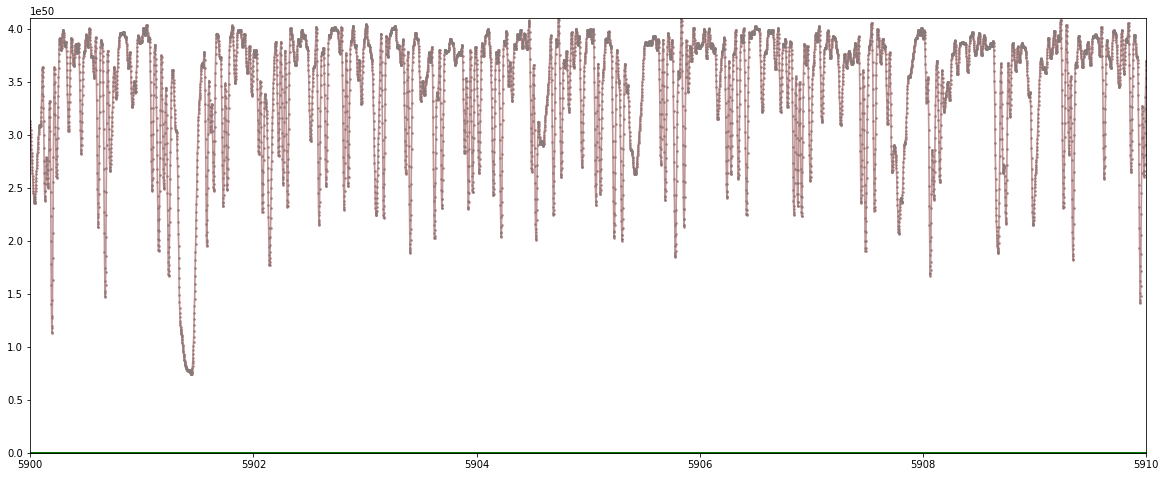

In [16]:
constant = np.mean(data['theory']['interpolated']['total']['flux'])
fig, ax = plt.subplots(figsize=(20,8))
plt.xlim(5900,5910)
plt.ylim(-.001,.4101e51)
# data.plot_flux(ax,0,['data','flux'],['data','wave'],pargs=simulacra.dataset.data_plot_settings,xy=False)
data.plot_flux(ax,0,['theory','interpolated','star','flux'],['theory','interpolated','total','wave'],xy=False,pargs={**simulacra.dataset.star_settings,**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
data.plot_flux(ax,0,['theory','interpolated','tellurics','flux'],['theory','interpolated','total','wave'],xy=False,pargs={**simulacra.dataset.tellurics_settings,**simulacra.dataset.interpolated_settings})
data.plot_flux(ax,0,['theory','interpolated','gascell','flux'],['theory','interpolated','total','wave'],xy=False,pargs={**simulacra.dataset.gas_settings,**simulacra.dataset.interpolated_settings})
data.plot_flux(ax,0,['theory','interpolated','total','flux'],['theory','interpolated','total','wave'],xy=False,pargs={'color':'gray',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
data.plot_flux(ax,0,['theory','lsf','flux'],['theory','interpolated','total','wave'],pargs={'color':'pink',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
data.plot_flux(ax,0,['theory','interpolated','total','flux'],['theory','interpolated','total','wave'],xy=False,pargs={'color':'gray',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
# data.plot_flux(ax,0,['theory','lsf','flux'],['theory','interpolated','total','wave'],pargs={'color':'pink',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
plt.show()

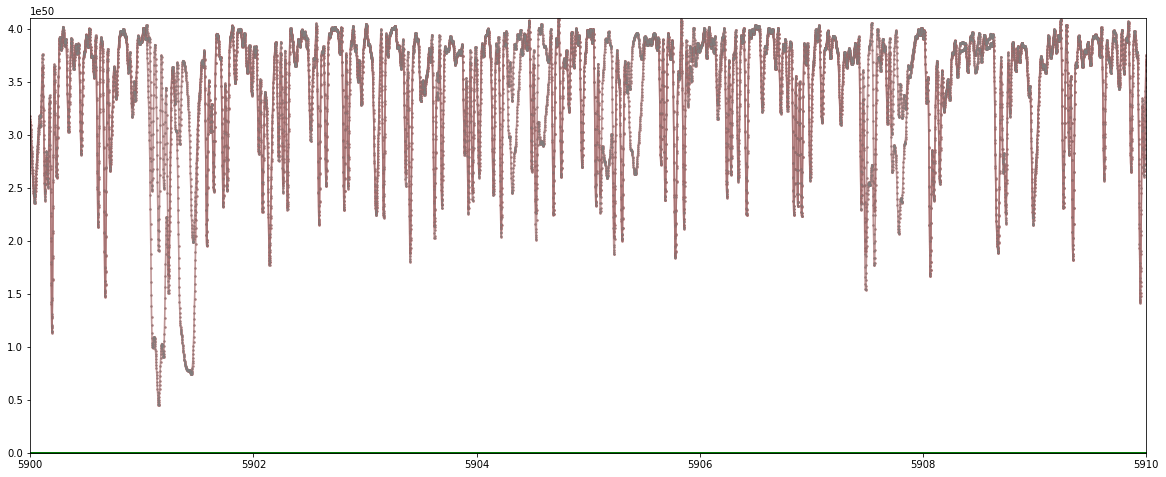

In [17]:
sort_times = np.argsort(obs_times)
constant = np.mean(data['theory']['interpolated']['total']['flux'])
fig, ax = plt.subplots(figsize=(20,8))
plt.xlim(5900,5910)
plt.ylim(-.001,.4101e51)

for i in range(2):
    data.plot_flux(ax,sort_times[i],['theory','interpolated','star','flux'],['theory','interpolated','total','wave'],xy=False,pargs={**simulacra.dataset.star_settings,**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
    data.plot_flux(ax,sort_times[i],['theory','interpolated','tellurics','flux'],['theory','interpolated','total','wave'],xy=False,pargs={**simulacra.dataset.tellurics_settings,**simulacra.dataset.interpolated_settings})
    data.plot_flux(ax,sort_times[i],['theory','interpolated','gascell','flux'],['theory','interpolated','total','wave'],xy=False,pargs={**simulacra.dataset.gas_settings,**simulacra.dataset.interpolated_settings})
    data.plot_flux(ax,sort_times[i],['theory','interpolated','total','flux'],['theory','interpolated','total','wave'],xy=False,pargs={'color':'gray',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
    data.plot_flux(ax,sort_times[i],['theory','lsf','flux'],['theory','interpolated','total','wave'],pargs={'color':'pink',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
    data.plot_flux(ax,sort_times[i],['theory','interpolated','total','flux'],['theory','interpolated','total','wave'],xy=False,pargs={'color':'gray',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
    # data.plot_flux(ax,0,['theory','lsf','flux'],['theory','interpolated','total','wave'],pargs={'color':'pink',**simulacra.dataset.interpolated_settings},normalize=normalize,nargs=[constant])
plt.show()
    


In [18]:
from simulacra.dataset import print_keys
print_keys(data)

data: <class 'dict'>
--obs_times: <class 'numpy.ndarray'>
--exp_times: <class 'astropy.units.quantity.Quantity'>
--epoches: <class 'int'>
--rvs: <class 'astropy.units.quantity.Quantity'>
--snr: <class 'numpy.ndarray'>
--flux_expected: <class 'numpy.ndarray'>
--flux: <class 'numpy.ndarray'>
--wave: <class 'astropy.units.quantity.Quantity'>
--ferr: <class 'numpy.ndarray'>
theory: <class 'dict'>
--star: <class 'dict'>
----flux: <class 'astropy.units.quantity.Quantity'>
----wave: <class 'astropy.units.quantity.Quantity'>
----deltas: <class 'astropy.units.quantity.Quantity'>
--interpolated: <class 'dict'>
----tellurics: <class 'dict'>
------flux: <class 'numpy.ndarray'>
----gascell: <class 'dict'>
------flux: <class 'numpy.ndarray'>
----star: <class 'dict'>
------flux: <class 'numpy.ndarray'>
------wave: <class 'astropy.units.quantity.Quantity'>
----total: <class 'dict'>
------flux: <class 'numpy.ndarray'>
------wave: <class 'astropy.units.quantity.Quantity'>
--tellurics: <class 'dict'>
---

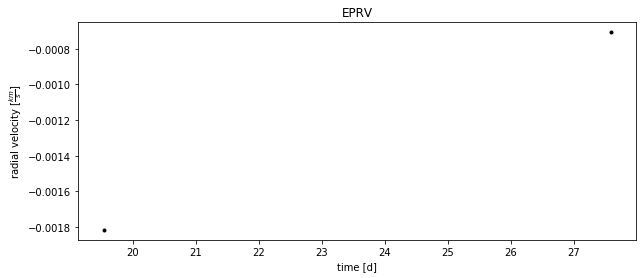

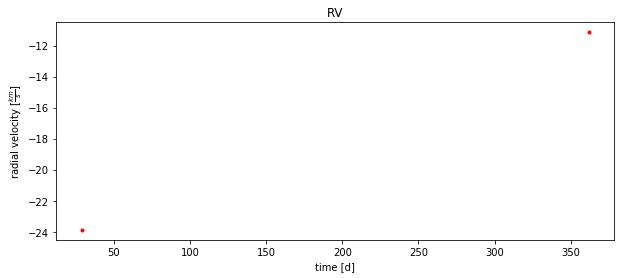

In [19]:
times = at.Time([obs_times[i] + exp_times[i]/2 for i in range(len(obs_times))])
periodic_times = np.array([(x-at.Time.now()).to(u.day).value % period.to(u.day).value for x in times])

rv = data['data']['rvs'].to(u.km/u.s)
bc  = target.radial_velocity_correction(obstime=times,location=loc).to(u.km/u.s)
eprv = rv - bc

plt.figure(figsize=(10,4))
plt.title('EPRV')
plt.plot(periodic_times,eprv.value,'.k')
plt.ylabel('radial velocity [$\\frac{km}{s}$]')
plt.xlabel('time [d]')
plt.show()

plt.figure(figsize=(10,4))
plt.title('RV')
plt.plot([(x - tstart).to(u.day).value for x in times],rv.value,'.r')
plt.ylabel('radial velocity [$\\frac{km}{s}$]')
plt.xlabel('time [d]')
plt.show()